# Data Loading
The data is downloaded locally, the date columns are specified and the data is saved to a DataFrame object 'loans_data' for further analysis.
It is important to note that the first sheet of original xls file (which contains the loans data itself) has been converted into a .csv file -> this is to enable quicker data loading/processing. Additionally, within the .csv file, the formats of the data columns have been altered to allow them to be parsed correctly as dates - using the additional 'parse_dates' and 'dayfirst' .read_csv() paramaters

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd

# shows all rows/columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# removes warning
pd.set_option('mode.chained_assignment', None)

# file path (in my uni OneDrive)
data_path = 'C://Users/*****/******/*****/Spring/Data Mining/CW2/LendingClubLoans2018-2020 (1).csv'

# columns containing dates
# the format for each of these columns has been altered in the .csv file to ensure they are parsed as dates
date_columns = ['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'payment_plan_start_date']

# load loans_data to dataframe, with dates parsed correctly
loans_data = pd.read_csv(data_path, parse_dates=date_columns, dayfirst=True)

# save the loans_data dataframe for use in different notebook if necessary
%store loans_data

print("Data Loading Complete!")

### -----> Note that exploratory analysis and data visualision was undertaken separately at this point (in a different notebook) to keep the underlying procedure legibile/understandable. <-----

# Columns/Row Removal
#### Columns and rows which are either useless and/or compromise the validity of results are removed:
- A number of feature values won't be known at the time of loan application - these are removed accordingly (to mimic real-life application)
- 'id' is removed - offers no value to our model.
- All loans which are incomplete (either not paid off, charged off or default) are removed from the dataset. We are only interested in complete loans for the purposes of classifying whether a loan is 'good' or 'bad'.
- All columns with more greater than 50% missing values are also removed as these will not be useful in classification.
- All columns with 0 variance are removed - these columns will provide no useful information.
- All repeated rows are removed (though none exist in this dataset).
- If a column is highly correlated abs(>= 0.99) with another column, one of these is removed as it is redundant.

In [ ]:
# based on comprehension of the data, the following features won't be known at time of loan application
# thus will need to be removed to maintain validity
unwanted_columns = [
    'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
    'out_prncp', 'out_prncp_inv', 'hardship_flag', 'last_fico_range_high', 'last_fico_range_low', 
    'id' # randomly assigned number -> useless
]

# narrow down initial dataframe to useful columns
for col in unwanted_columns:
    if col in loans_data:
        loans_data.drop(col, axis=1, inplace=True)

# similarly remove 'Current' loans from the dataset
# these won't help in classification as their ultimate status as 'good' or 'bad' remains unknown
loans_data = loans_data[loans_data.loan_status != 'Current']

# remove loans in grace period and late - these categories are too fuzzy (in between good and bad and the loans are incomplete)
loans_data = loans_data[loans_data.loan_status != 'In Grace Period']
loans_data = loans_data[loans_data.loan_status != 'Late (16-30 days)']
loans_data = loans_data[loans_data.loan_status != 'Late (31-120 days)']

# remove columns with with lots of missing values
loans_data = loans_data[loans_data.columns[loans_data.isnull().mean() < 0.5]]

# removes columns with 0 variation
# in this case, 'pymnt_plan' is always 'n' so offers no value to the model
for column in loans_data:
    if len(loans_data[column].unique()) == 1:
        loans_data.drop([column], axis=1, inplace=True)

# drops duplicate rows if any exist
# in this case, no duplicate rows are present
loans_data.drop_duplicates(inplace=True)

# drop one of a pair of highly correlated columns -> analysis to determine correlation done in separate notebook
correlated_cols_to_drop = ['num_sats']
for col in correlated_cols_to_drop:
    # checks if col is present first to prevent error messages
    if col in loans_data:
        loans_data.drop(columns=col, inplace=True)

# check the new df dimensions to ensure cols/rows have been removed
print(f"Column/Row removal complete -> {loans_data.shape}")


# Feature Transformation
- Percentage columns need to be cleaned -> stripped of % and then converted to a decimal
- The remaining datetime feature is transformed to a duration. Rather than the date of the earliest credit line, it now displays the number of years since the first credit line was opened - creating a useful feature which examines how long an applicant has had a credit history.
- Similarly, 'term' is currently a string. It is stripped of non numeric characters and converted to an integer.
- To reduce some dimensions once features are OHEncoded, really rare instances of 'home_ownership' and 'purpose' are converted to 'other'.



In [99]:
import datetime

# check the initial datatypes of the df
print(f"Current datatype counts:\n{loans_data.dtypes.value_counts()}")

# object columns that need to be converted to percentages
percentage_columns = ['int_rate', 'revol_util']

for col in loans_data[percentage_columns]:
    if loans_data[col].dtype == object:
        # convert the 'int_rate' object to floats -> strip % sign, convert to float, divide by 100 to get decimal value
        loans_data[col] = loans_data[col].str.strip('%').astype('float')/100

# 'if' to prevent error messages if cell is run again
if 'earliest_cr_line' in loans_data:
    # create new feature based on the number of years since the earliest credit line
    current_year = datetime.datetime.now().year # get current year
    loans_data.earliest_cr_line = pd.DatetimeIndex(loans_data.earliest_cr_line).year # get just the year value
    # convert from datetime to numeric value and deduct from the current year (to get years since earliest_cr_line)
    loans_data.earliest_cr_line = current_year - pd.to_numeric(loans_data.earliest_cr_line)
    # rename variable accordingly for improved readability
    loans_data.rename(columns={'earliest_cr_line': 'years_since_first_cr_line'}, inplace=True)

# transform term string to numeric month value
if 'term' in loans_data:
    if loans_data['term'].dtype == object:
        loans_data['term'] = loans_data['term'].str.split(' ').str[0].astype('int')
        
# create 'Other' category to remove some columns once OHencoded - only one of each instance
# will reduce columns by 1
home_ownership_dict = {
    'NONE': 'Other',
    'ANY': 'Other',
}
if 'home_ownership' in loans_data:
    loans_data.home_ownership = loans_data.home_ownership.map(home_ownership_dict).fillna(loans_data.home_ownership)

# convert to 'other' category to remove some columns once OHencoded
# will reduce columns by 2
purpose_dict = {
    'wedding': 'other',
    'renewable_energy': 'other'
}
if 'purpose' in loans_data:
    loans_data.purpose = loans_data.purpose.map(purpose_dict).fillna(loans_data.purpose)

print(f"\nNew datatype counts (following datetime/percentages/months feature transformation):\n{loans_data.dtypes.value_counts()}")

Current datatype counts:
int64             35
float64           25
object            11
datetime64[ns]     1
dtype: int64

New datatype counts (following datetime/percentages/months feature transformation):
int64      36
float64    27
object      8
int32       1
dtype: int64


# Feature Engineering
A series of features are created, using lambda functions, to more effectively encode domain information into the model.

In [100]:
# attempt to quantify how affordable the loan is
loans_data['amnt_div_by_ann_inc'] = loans_data.apply(lambda x: x.annual_inc / x.loan_amnt, axis=1)

# get one fico score (as opposed to 2 correlated columns)
loans_data['fico_range_avg'] = loans_data.apply(lambda x: (x.fico_range_high + x.fico_range_low)/2, axis=1)

# see if a job title has been given
loans_data['job_title_provided'] = loans_data['emp_title'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# again, see how affordable the loan is over the longer term
loans_data['amnt_div_by_term_times_int_rate'] = loans_data.apply(lambda x: x.loan_amnt / x.term * x.int_rate, axis=1)

# get a pseudo disposable income feaute
loans_data['disposable_income'] = loans_data.apply(lambda x: x.avg_cur_bal - x.installment, axis=1)

# drop some more columns that are no longer needed
loans_data.drop(columns=['fico_range_low', 'fico_range_high', 'emp_title', 'installment'], inplace=True)

print("New columns added successfully!")

New columns added successfully!


-------------------------------------------------------------------------------------------------------------------------------

# Encoding
The remaining categorical features need to be encoded for use in our model.
- Categories with a hierarchy are ordinally encoded to maintain the order.
- Binary categories with just 2 classes can be label encoded (changed to 0/1).
- Multi class categories must be OHE and additional columns are added. The code to do this is adapted from: https://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example

In [101]:
from sklearn.preprocessing import LabelEncoder

# encoding target variable -> 0 = good loan, 1 = bad loan
loan_status_encoding_dict = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1
}
loans_data.loan_status = loans_data.loan_status.map(loan_status_encoding_dict) # new numeric values are mapped to y


# ordinally encode grade column -> ordinal encoding used here as an obvious order exists between categories
grade_encoding_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}
loans_data.grade = loans_data.grade.map(grade_encoding_dict) # new numeric are mapped to new_loans_data.grade


# these columns have just 2 classes (and can be encoded using LabelEncoder)
binary_cat_columns = ['application_type', 'initial_list_status']
le = LabelEncoder()
for col in binary_cat_columns:
    if col in loans_data:
        loans_data[col] = le.fit_transform(loans_data[col])

# these columns have multiple classes and thus, one_hot_encoding should be used here
multi_cat_columns = ['home_ownership', 'verification_status', 'purpose']

# create new columns for each category in each of the multi_cat_columns
new_cols = pd.get_dummies(loans_data, columns=multi_cat_columns)

# drop the original multi_cat_columns
loans_data.drop(multi_cat_columns, axis=1, inplace=True)

# merge the original new_loans_data df with the newly created new_cols dataframe
loans_data = loans_data.merge(new_cols)

print("Dataset successfully encoded!")
print(loans_data.dtypes.value_counts())

Dataset successfully encoded!
int64      37
float64    30
uint8      18
int32       3
dtype: int64


-------------------------------------------------------------------------------------------------------------------------------

# Dropping Rows with lots of missing values
- following viewing the missing value counts of the remaining freatures, we can see that the below subset of columns all have the same amount of data missing, from the same columns. Thus, these rows are removed from the dataset

In [102]:
# drop 3000 rows which are all missing the same data
loans_data.dropna(subset=[
   'total_bal_il', 'open_acc_6m', 'inq_last_12m', 'max_bal_bc', 'open_act_il', 'open_il_24m',
   'open_rv_12m', 'open_rv_24m', 'inq_fi', 'open_il_12m', 'total_cu_tl'], how='any', inplace=True)

print("Rows dropped!")
print(loans_data.shape)

# save cleaned data to csv
loans_data.to_csv('cleaned_loans_data')

Rows dropped!
(41422, 88)


-------------------------------------------------------------------------------------------------------------------------------

# Train/Test Split
- The data is first split into X (features) and y (target column).
- Next both X and y and split (in a stratified way) into training (75%) and test (25%) data

In [103]:
from sklearn.model_selection import train_test_split

try:
    y = loans_data.loan_status
    loans_data.drop('loan_status', axis=1, inplace=True)
    X = loans_data
except:
    pass

# split into train and test sets (stratify based on the target variable to help with balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

print("Data split!")

Data split!


-------------------------------------------------------------------------------------------------------------------------------

# Imputation
- Imputation is done post split to prevent data leakage. Following the testing of different methods (mean, knn and median), it was found the median imputation (in terms of f-score), was the best imputation method for all columns. The imputer is fit on the training data and then used to transform both the training and test data, to prevent data leakage.

In [104]:
from sklearn.impute import SimpleImputer

columns_for_median_imp = ['bc_open_to_buy', 'avg_cur_bal', 'dti', 'all_util',
                         'mths_since_rcnt_il', 'revol_util', 'percent_bc_gt_75', 'bc_util',
                          'mths_since_recent_inq', 'il_util', 'mths_since_recent_bc', 'mo_sin_old_il_acct', 'disposable_income']

si_median = SimpleImputer(strategy='median')

X_train[columns_for_median_imp] = si_median.fit_transform(X_train[columns_for_median_imp])
X_test[columns_for_median_imp] = si_median.transform(X_test[columns_for_median_imp])

print("Median Imputation complete!")
print(f"Missing values remaining: ({X_train.isna().sum().sum()}, {X_test.isna().sum().sum()}) = (train, test)")

Median Imputation complete!
Missing values remaining: (0, 0) = (train, test)


# Scaling
Scaling is used here to standardise the columns so that columns with varying units/size/ranges are considered fairly. The scaler is fit (and transformed) on the training and then used to transform the test set

In [105]:
from sklearn.preprocessing import StandardScaler

# create scaler object
scaler = StandardScaler()
# fit on training data and transform
X_train = scaler.fit_transform(X_train)
# transform test data
X_test = scaler.transform(X_test)

print("Scaling complete!")

Scaling complete!


# Resampling
Undersampling is used to remove instances of the majority class and balance the dataset. Undersampling was chosen after comparing results of different sampling methods - SMOTE, oversampling etc. And was deemed the most effective method. Only the training data is resampled so that the test data mirrors real life data (which will not be balanced).

In [106]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import scale

# reduce the majority class to mirror the number of minority class instances (1:1)
under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=0)

# resample just the training set
# test set is untouched to mirror real life application
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

print(f"Undersampling complete! -> {X_train.shape} {X_train_resampled.shape}")

Undersampling complete! -> (31066, 87) (14342, 87)


# Feature Selection
An automatic feature selection algorithm is run, in conjunction with crossvalidation on the logistic regression model, to choose the best n features.

In [107]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# use basic lr for feature selection, before the parameters are tuned shortly
lr = LogisticRegression(random_state=0, max_iter=10000)

# selector will choose the best n features (in terms of roc_auc), using cv to ensure no overfitting
selector = RFECV(estimator=lr, cv=3, scoring='roc_auc', step=5)

# fit/transform training set
X_train_fs = selector.fit_transform(X_train_resampled, y_train_resampled)
# just transform test set
X_test_fs = selector.transform(X_test)

print("Feature Selection complete!")
print(f"Optimal num of features: {selector.n_features_}")
# optimal features = 57

Feature Selection complete!
Optimal num of features: 57


# Cross Validation, HyperParameter Tuning & Model Training

## Logistic Regression
Crossvalidation is used in conjunction with hyperparameter tuning to ensure no overfitting. The resultant parameters found are hard coded here as the algorithm takes a long time to run. Parts of the code for hyperparameter tuning are adapted from: https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

In [108]:
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1.0, 10, 100]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='balanced_accuracy', error_score=0)
grid_result = grid_search.fit(X_train_fs, y_train_resampled)

print(f"Best Parameters Found: {grid_result.best_params_}")
print(f"Score: {grid_result.best_score_}")


# THE RESULT IS THIS BELOW. IT IS THEN HARDCODED TO THE LR IN THE NEXT CELL AS IT TAKES TOO MUCH TIME TO RUN AGAIN

# Best Parameters Found: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
# Score: 0.6549068013094955

Best Parameters Found: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Score: 0.6549068013094955


# Fit the LogisticRegression Model
Using the parameters from CV/hyperparamter tuning. max_iter is necessary to ensure the model converges.

In [109]:
lr = LogisticRegression(random_state=0, max_iter=10000, solver='liblinear', penalty='l2', C=0.01)
lr.fit(X_train_fs, y_train_resampled)

LogisticRegression(C=0.01, max_iter=10000, random_state=0, solver='liblinear')

In [110]:
from sklearn.svm import LinearSVC

# the parameters were determing using CV hyperparamter optimisation
svc = LinearSVC(random_state=0, C=1.0, loss='squared_hinge', max_iter=10000)
svc.fit(X_train_fs, y_train_resampled)

C:\Users\napag\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=10000, random_state=0)

# Model Evaluation


LogisticRegression:


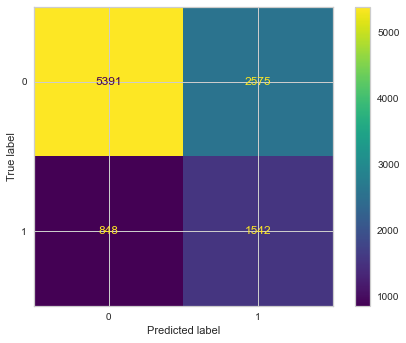

              precision    recall  f1-score   support

           0       0.86      0.68      0.76      7966
           1       0.37      0.65      0.47      2390

    accuracy                           0.67     10356
   macro avg       0.62      0.66      0.62     10356
weighted avg       0.75      0.67      0.69     10356

Accuracy Score: 0.6694669756662804
Balanced Accuracy Score: 0.6609697385436222
ROC_AUC score: 0.7235315467305083


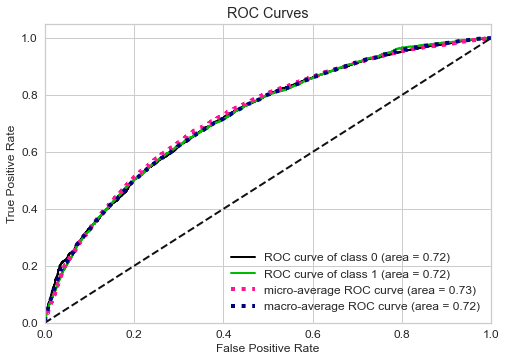

----------------------------------


In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, auc, roc_curve
from sklearn.model_selection import cross_val_score

import scikitplot as skplt

classifiers = [lr]

for c in classifiers:
    print(f"\n{c.__class__.__name__}:")
    # create, plot and show the confustion matrix
    cm = confusion_matrix(y_test, c.predict(X_test_fs))
    plot_confusion_matrix(c, X_test_fs, y_test)
    plt.show()
    
    print(classification_report(y_test, c.predict(X_test_fs)))
    print(f"Accuracy Score: {accuracy_score(y_test, c.predict(X_test_fs))}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, c.predict(X_test_fs))}")
    
    # for different models, .decision_function() may not work
    try:
        print(f"ROC_AUC score: {roc_auc_score(y_test, c.decision_function(X_test_fs))}")
    except:
        print(f"ROC_AUC score: {roc_auc_score(y_test, c.predict_proba(X_test_fs)[:, 1])}")
    
    # view ROC curve
    skplt.metrics.plot_roc(y_test, c.predict_proba(X_test_fs))
    plt.show() 
    
    print("----------------------------------")

    

# Unsupervised Clustering

# Find Optimal K
First, we create a kmeans model and fit using the already cleaned/preproccesed (unlabeled) training data. Training data is used as it is the larger part of the dataset and is almost ready for clustering. To find the ideal number of clusters, the elbow method is used and we iterate through 1-10 'k's, and find the the optimal value for k=3.

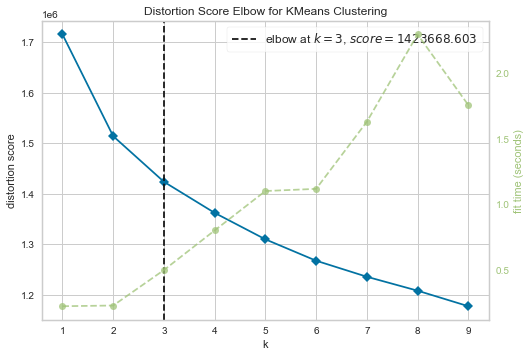

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [113]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from sklearn.decomposition import PCA

pca = PCA(n_components=20)
df = pca.fit_transform(X_train)

km = KMeans(random_state=0)
vis = KElbowVisualizer(km, k=(1,10))
vis.fit(df)
vis.show()

# Kmeans with optimal K
The kmeans algorithm is fit again with the optimal value of k (3) entered.

In [114]:
km = KMeans(n_clusters=3, random_state=0)

km.fit_predict(df)

array([1, 2, 2, ..., 2, 2, 2])

# KMeans Evaluation
Here, 2 metrics are used to evaluate the effectiveness of the clustering. Silhouette Score looks at how distinct the clusters are. Adjusted Rand Score looks at how closely the predictions match the actual labels.

In [115]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

s_score = silhouette_score(
    df, km.labels_).round(6)

ar_score = adjusted_rand_score(y_train, km.labels_).round(6)

print(f"Silhouette Score: {s_score}")
print(f"Adjusted Rand Score: {ar_score}")
# Silhouette Score: 0.09482
# Adjusted Rand Score: 0.002394


Silhouette Score: 0.109958
Adjusted Rand Score: 0.002411


# PCA
Use PCA to reduce the dimensions (to 2d and 3d) so that both can be visualised (and compared to actual labels).

In [116]:
from sklearn.decomposition import PCA

pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)


df_2 = pca_2.fit_transform(df)
df_3 = pca_3.fit_transform(df)


# Clustering Visualisation

Now it is possible to visualise the actual and predicted labels in 2d and 3d.

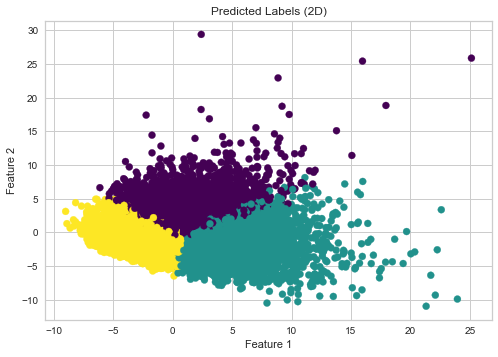

0    0
1    0
2    0
3    0
4    0
Name: loan_status, dtype: int64


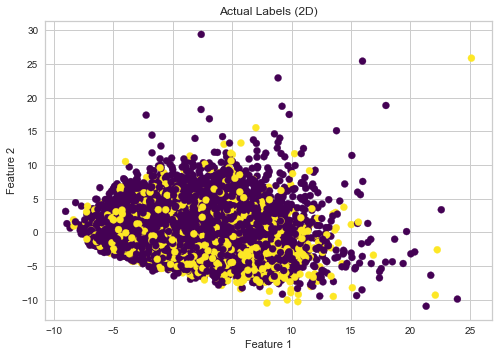

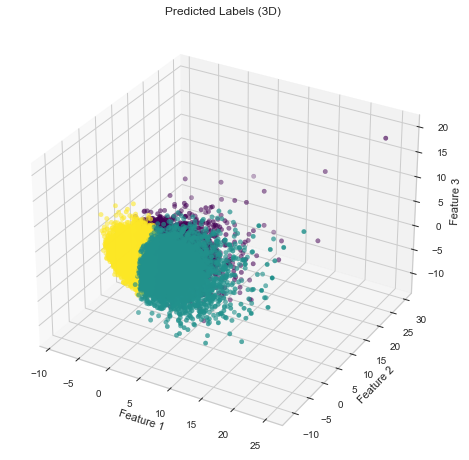

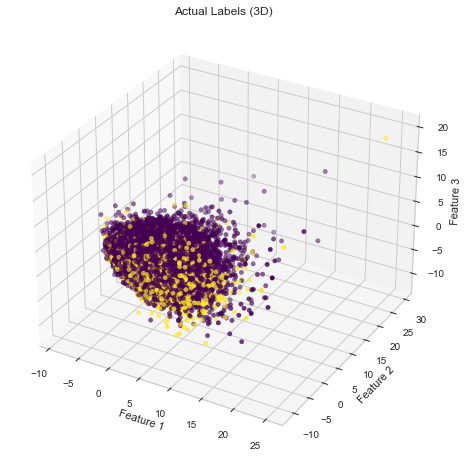

In [117]:
from mpl_toolkits.mplot3d import Axes3D

# view predicted 2d clusters
plt.title('Predicted Labels (2D)')
plt.scatter(df_2[:, 0], df_2[:, 1], c=km.labels_, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# view actual 2d clusters
plt.title('Actual Labels (2D)')
plt.scatter(df_2[:, 0], df_2[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# view predicted clusters
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(df_3[:,0], df_3[:,1], df_3[:,2], c=km.labels_, cmap='viridis')
ax.set_title('Predicted Labels (3D)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

# view actual clusters
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(df_3[:,0], df_3[:,1], df_3[:,2], c=y_train, cmap='viridis')
ax.set_title('Actual Labels (3D)')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()